In [24]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import Wrapper, AveragePooling2D, LeakyReLU, BatchNormalization, UpSampling2D, GlobalAveragePooling2D, Reshape
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import numpy as np


tf.__version__
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
class SpectralNormalization(Wrapper):
    """
    Attributes:
       layer: tensorflow keras layers (with kernel attribute)
    """

    def __init__(self, layer, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        """Build `Layer`"""

        if not self.layer.built:
            self.layer.build(input_shape)

            if not hasattr(self.layer, 'kernel'):
                raise ValueError(
                    '`SpectralNormalization` must wrap a layer that'
                    ' contains a `kernel` for weights')

            self.w = self.layer.kernel
            self.w_shape = self.w.shape.as_list()
            self.u = self.add_variable(
                shape=tuple([1, self.w_shape[-1]]),
                initializer=k.initializers.TruncatedNormal(stddev=0.02),
                name='sn_u',
                trainable=False,
                dtype=tf.float32)

        super(SpectralNormalization, self).build()

    @tf.function
    def call(self, inputs):
        """Call `Layer`"""
        # Recompute weights for each forward pass
        self._compute_weights()
        output = self.layer(inputs)
        return output

    def _compute_weights(self):
        """Generate normalized weights.
        This method will update the value of self.layer.kernel with the
        normalized value, so that the layer is ready for call().
        """
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        eps = 1e-12
        _u = tf.identity(self.u)
        _v = tf.matmul(_u, tf.transpose(w_reshaped))
        _v = _v / tf.maximum(tf.reduce_sum(_v**2)**0.5, eps)
        _u = tf.matmul(_v, w_reshaped)
        _u = _u / tf.maximum(tf.reduce_sum(_u**2)**0.5, eps)

        self.u.assign(_u)
        sigma = tf.matmul(tf.matmul(_v, w_reshaped), tf.transpose(_u))

        self.layer.kernel = self.w / sigma

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())

In [0]:
class ResBlockDown(Model):
  def __init__(self, channels):
    super(ResBlockDown, self).__init__()
    self.lr1 = LeakyReLU(alpha=0.2)
    self.lr2 = LeakyReLU(alpha=0.2)
    self.conv33_1 = SpectralNormalization(Conv2D(filters=channels, kernel_size=3, padding='same'))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=channels, kernel_size=3, padding='same'))
    self.conv11 = SpectralNormalization(Conv2D(filters=channels, kernel_size=1, padding='same'))
    self.av_pool_1 = AveragePooling2D(padding='same')
    self.av_pool_2 = AveragePooling2D(padding='same')
  
  def call(self, x):
    rhs = self.lr1(x)
    rhs = self.conv33_1(rhs)
    rhs = self.lr2(rhs)
    rhs = self.conv33_2(rhs)
    rhs = self.av_pool_1(rhs)
    x = self.conv11(x)
    x = self.av_pool_2(x)
    return x + rhs

In [0]:
class ResBlockUp(Model):
  def __init__(self, channels):
    super(ResBlockUp, self).__init__()
    self.bn1 = BatchNormalization()
    self.bn2 = BatchNormalization()
    self.up_sample_1 = UpSampling2D()
    self.up_sample_2 = UpSampling2D()
    self.lr1 = LeakyReLU(alpha=0.2)
    self.lr2 = LeakyReLU(alpha=0.2)
    self.conv33_1 = SpectralNormalization(Conv2D(filters=channels, kernel_size=3, padding='same'))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=channels, kernel_size=3, padding='same'))
    self.conv11 = SpectralNormalization(Conv2D(filters=channels, kernel_size=1, padding='same'))

  def call(self, x):
    rhs = self.bn1(x)
    rhs = self.lr1(rhs)
    rhs = self.up_sample_1(rhs)
    rhs = self.conv33_1(rhs)
    rhs = self.bn2(rhs)
    rhs = self.lr2(rhs)
    rhs = self.conv33_2(rhs)
    x = self.up_sample_2(x)
    x = self.conv11(x)
    return x + rhs

In [0]:
class NonLocalBlock(Model):
  def __init__(self):
    super(NonLocalBlock, self).__init__()
    self.spec_conv_f = SpectralNormalization(Conv2D(filters=64, kernel_size=1, padding='same'))
    self.spec_conv_g = SpectralNormalization(Conv2D(filters=64, kernel_size=1, padding='same'))
    self.spec_conv_h = SpectralNormalization(Conv2D(filters=64, kernel_size=1, padding='same'))
    self.spec_conv_o = SpectralNormalization(Conv2D(filters=64, kernel_size=1, padding='same'))

  def call(self, x):
    f = self.spec_conv_f(x)
    g = self.spec_conv_g(x)
    h = self.spec_conv_h(x)
    s = tf.matmul(g, f, transpose_b=True)
    beta = tf.nn.softmax(s, axis=-1)
    o = tf.matmul(beta, h)
    o = self.spec_conv_o(o)
    
    return o


In [0]:
class Generator(Model):
  def __init__(self, channels):
    super(Generator, self).__init__()
    self.channels = channels
    self.linear = Dense(7*7*4*channels, use_bias=False)
    self.reshape = Reshape([7, 7, 4*channels])
    self.res_block_1 = ResBlockUp(2*channels)
    self.non_local_block = NonLocalBlock()
    self.res_block_2 = ResBlockUp(channels)
    self.bn = BatchNormalization()
    self.lr = LeakyReLU(alpha=0.2)
    self.conv = Conv2D(filters=1, kernel_size=3, padding='same')

  @tf.function
  def call(self, x):
    x = self.linear(x)
    x = self.reshape(x)
    x = self.res_block_1(x)
    x = self.non_local_block(x)
    x = self.res_block_2(x)
    x = self.bn(x)
    x = self.lr(x)
    x = self.conv(x)
    return tf.nn.tanh(x)

In [0]:
class Discriminator(Model):
  def __init__(self, channels):
    super(Discriminator, self).__init__()
    self.res_block_1 = ResBlockDown(2*channels)
    self.non_local_block = NonLocalBlock()
    self.res_block_2 = ResBlockDown(4*channels)
    self.lr = LeakyReLU(alpha=0.2)
    self.pooling = GlobalAveragePooling2D()
    self.linear = Dense(1)
  
  @tf.function
  def call(self, x):
    x = self.res_block_1(x)
    x = self.non_local_block(x)
    x = self.res_block_2(x)
    x = self.lr(x)
    x = self.pooling(x)
    return self.linear(x)


In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 100

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

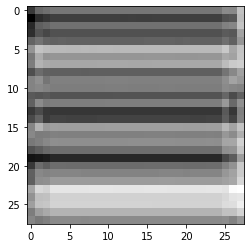

In [34]:
generator = Generator(256)
noise = tf.random.truncated_normal([1, 120], stddev=0.5)
generated_image = generator(noise)
generated_image.shape
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [35]:
discriminator = Discriminator(128)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.0001141]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.01)
discriminator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.01)
checkpoint_dir = './drive/My Drive/training_checkpoints_'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
skip_iter = 1

def train_step(images, iteration):
    noise = tf.random.truncated_normal([BATCH_SIZE, 120], stddev=0.5)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise)

      real_output = discriminator(images)
      fake_output = discriminator(generated_images)
      real_correct = np.count_nonzero(real_output.numpy() > 0.9)
      fake_correct = np.count_nonzero(fake_output.numpy() < 0.1)
      tf.print(f'real: {real_correct}, fake: {fake_correct}')
      disc_loss = discriminator_loss(real_output, fake_output)
      if iteration % skip_iter == 0:
        gen_loss = generator_loss(fake_output)
        tf.print(f'generator loss: {gen_loss},      discriminator loss: {disc_loss}')
    if (iteration % skip_iter == 0) and real_correct >= 30:
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    else:
      tf.print('skip training gen')
    if (fake_correct + real_correct) <= (2*BATCH_SIZE - 10):
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    else:
      tf.print('skip training disc')

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for i, image_batch in enumerate(dataset):
      if i % 10 == 0:
        tf.print(i)
      train_step(image_batch, i)

    display.clear_output(wait=True)
    if (epoch + 1) % 2 == 0:
      tf.print('saving checkpoint')
      checkpoint.save(file_prefix = checkpoint_prefix)
    test_input = tf.random.truncated_normal([16, 120], stddev=0.5)
    predictions = generator(test_input)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./drive/My Drive/training_checkpoints_/pics/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [43]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

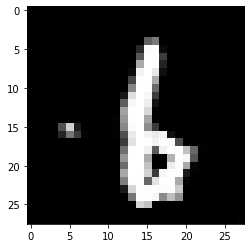

In [47]:
noise = tf.random.truncated_normal([1, 120], stddev=0.5)
generated_image = generator(noise)
generated_image.shape
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

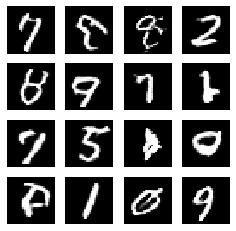

Time for epoch 21 is 164.0427656173706 sec
0
real: 138, fake: 101
generator loss: 0.6060031652450562,      discriminator loss: 1.2289592027664185
real: 3, fake: 252
generator loss: 1.1299906969070435,      discriminator loss: 1.347602128982544
skip training gen
real: 68, fake: 125
generator loss: 0.6609124541282654,      discriminator loss: 1.2192227840423584
real: 15, fake: 230
generator loss: 0.9468736052513123,      discriminator loss: 1.2153875827789307
skip training gen
real: 53, fake: 185
generator loss: 0.7757023572921753,      discriminator loss: 1.1361658573150635
real: 28, fake: 205
generator loss: 0.8435844779014587,      discriminator loss: 1.2068333625793457
skip training gen
real: 20, fake: 223
generator loss: 0.9094117879867554,      discriminator loss: 1.1779954433441162
skip training gen
real: 42, fake: 188
generator loss: 0.8410617709159851,      discriminator loss: 1.1662973165512085
real: 21, fake: 217
generator loss: 0.9153633117675781,      discriminator loss: 1.2

In [0]:
%%time
train(train_dataset, EPOCHS)

не обучать генератор если real < 10?
